# KMeans

In [1]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os, re

from sklearn.cluster          import KMeans

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV
from sklearn.cross_validation import cross_val_predict, permutation_test_score

In [2]:
SEED   = 97
scale  = False 
minmax = False
norm   = False
nointercept = True
engineering = False

N_CLASSES = 2

submission_filename = "../submissions/submission_KMeans.csv"

# Load the training data

In [3]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Train the model

In [4]:
StatifiedCV = StratifiedKFold(y            = y_train, 
                              n_folds      = 10, 
                              shuffle      = True, 
                              random_state = SEED)

In [5]:
%%time

random.seed(SEED)

clf = KMeans(n_clusters           = 2, 
             
             init                 = 'k-means++', # 'k-means++', 'random' or an ndarray
             n_init               = 10, 
             max_iter             = 300, 
             copy_x               = True,
             precompute_distances = 'auto',      # 'auto', True, False
             
             tol                  = 0.0001,
             verbose              = 0, 
             random_state         = SEED, 
             n_jobs               = 1)


# param_grid = dict(init                 = ['k-means++', 'random'],
#                   n_init               = [10, 50],
#                   max_iter             = [150, 300, 600],
#                   copy_x               = [True, False],
#                   precompute_distances = ['auto', True, False])

# grid_clf = GridSearchCV(estimator  = clf, 
#                         param_grid = param_grid,
#                         n_jobs     = -1,  
#                         cv         = StatifiedCV,
#                         verbose    = 0
#                        )

# grid_clf.fit(X = X_train, y = y_train)

# print("clf_params = {}".format(grid_clf.best_params_))
# print("score: {}".format(round(grid_clf.best_score_, 4)))
# print

# clf = grid_clf.best_estimator_




clf_params = {'copy_x':   True, 
              'init':     'k-means++', 
              'max_iter': 150, 
              'n_init':   10, 
              'precompute_distances': 'auto', 
              'n_jobs':   -1}
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

CPU times: user 32 ms, sys: 24 ms, total: 56 ms
Wall time: 174 ms


In [6]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='learning_rate', x_key='n_estimators')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

/home/george/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


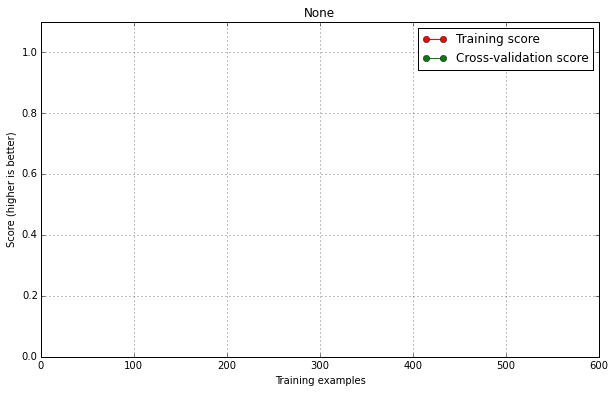

CPU times: user 2.13 s, sys: 972 ms, total: 3.1 s
Wall time: 8.87 s


In [7]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = 1)

plt.show()

# Training set predictions

In [8]:
%%time

train_preds = cross_val_predict(estimator    = clf, 
                                X            = X_train, 
                                y            = y_train, 
                                cv           = StatifiedCV, 
                                n_jobs       = 1, 
                                verbose      = 0, 
                                fit_params   = None, 
                                pre_dispatch = '2*n_jobs')

y_true, y_pred   = y_train, train_preds

CPU times: user 408 ms, sys: 200 ms, total: 608 ms
Wall time: 1.75 s


[[361  77]
 [102  36]]


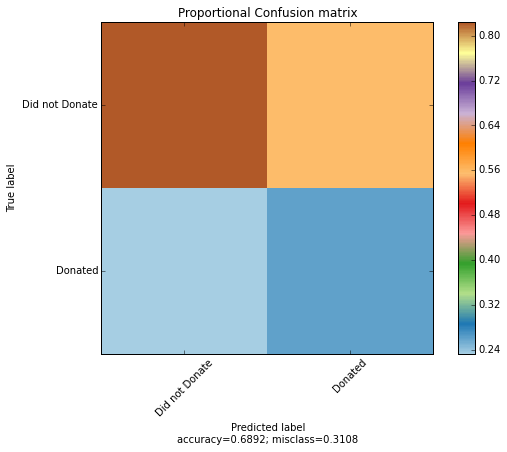

Accuracy 0.6892, mis-class rate 0.3108


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix

plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

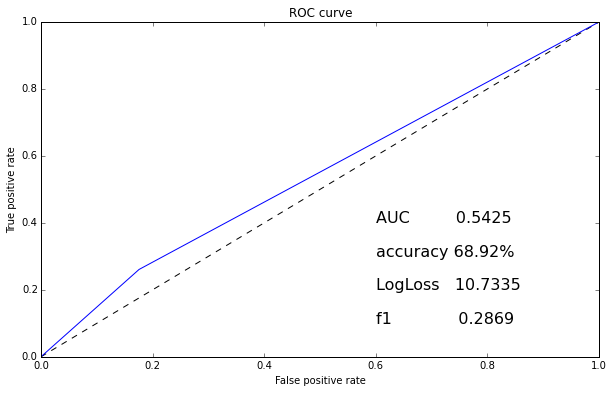

In [10]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

AUC = roc_auc_score(y_true, y_pred, average='macro')
plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(AUC),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

logloss = log_loss(y_true, y_pred)
plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(logloss),
        fontsize=16)

f1 = f1_score(y_true, y_pred)
plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

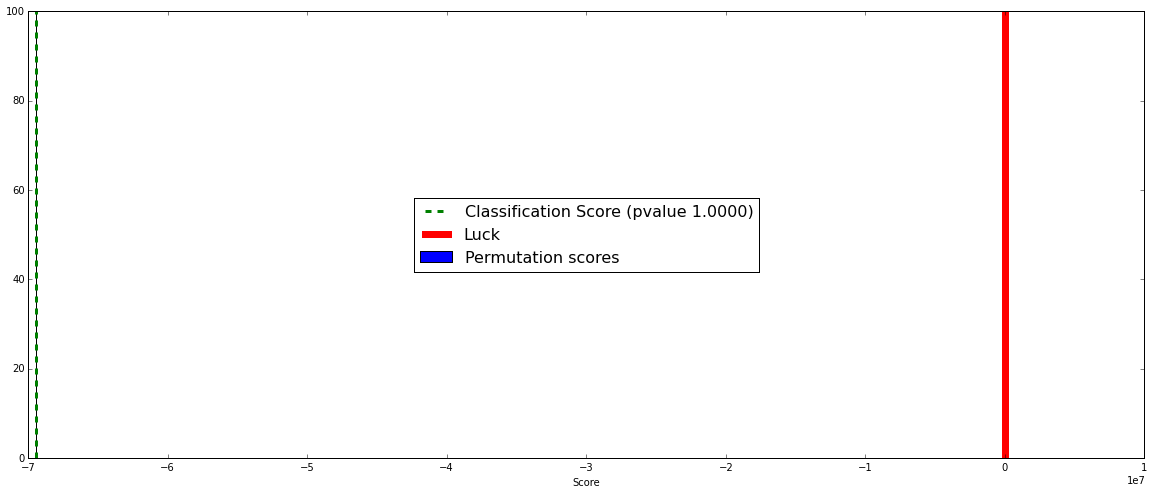

CPU times: user 38.8 s, sys: 21.4 s, total: 1min
Wall time: 2min 55s


In [11]:
%%time

score, permutation_scores, pvalue = permutation_test_score(estimator      = clf, 
                                                           X              = X_train.values.astype(np.float32), 
                                                           y              = y_train, 
                                                           cv             = StatifiedCV, 
                                                           labels         = None,
                                                           random_state   = SEED,
                                                           verbose        = 0,
                                                           n_permutations = 100, 
                                                           scoring        = None,
                                                           n_jobs         = 1) 

plt.figure(figsize=(20,8))
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score (pvalue {:.4f})'.format(pvalue))
         
plt.plot(2 * [1. / N_CLASSES], ylim, 'r', linewidth=7, label='Luck')

plt.ylim(ylim)
plt.legend(loc='center',fontsize=16)
plt.xlabel('Score')
plt.show()

# find mean and stdev of the scores
from scipy.stats import norm
mu, std = norm.fit(permutation_scores)

In [12]:
# format for scores.csv file
import re
algo = re.search(r"submission_(.*?)\.csv", submission_filename).group(1)
print("{: <26} ,        ,   {:.4f} ,  {:.4f} , {:.4f} , {:.4f} , {:.4f} , {:.4f}"\
      .format(algo,accuracy,logloss,AUC,f1,mu,std))

KMeans                     ,        ,   0.6892 ,  10.7335 , 0.5425 , 0.2869 , -69478760.9634 , 0.0000


# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Re-fit with the full training set

In [13]:
clf.set_params(**clf_params)
clf.fit(X_train, y_train)

KMeans(copy_x=True, init='k-means++', max_iter=150, n_clusters=2, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=97, tol=0.0001,
    verbose=0)

## Load the test data

In [14]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [15]:
y_pred = clf.predict(X_test)
print(y_pred[:10])

try:
    y_pred_probs  = clf.predict_proba(X_test)
    print(y_pred_probs[:10])
    donate_probs  = [prob[1] for prob in y_pred_probs]
except Exception,e:
    print(e)
    donate_probs = [0.65 if x>0 else 1-0.65 for x in y_pred]
    
print(donate_probs[:10])

[1 0 0 1 1 1 0 0 0 0]
'KMeans' object has no attribute 'predict_proba'
[0.65, 0.35, 0.35, 0.65, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35]


# Create the submission file

In [78]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()